In [1]:

import numpy as np
from numba import jit

In [2]:
def _A(j1, j2, j, m1, m2):
    '''Auxiliary function used in 3j recursion
    '''

    tempa = j**2 - (j1-j2)**2
    tempb = (j1+j2+1)**2 - j**2
    tempc = j**2 - (m1+m2)**2

    return np.sqrt(tempa*tempb*tempc)

@jit
def _Ajit(j1, j2, j, m1, m2):
    '''Auxiliary function used in 3j recursion
    '''

    tempa = j**2 - (j1-j2)**2
    tempb = (j1+j2+1)**2 - j**2
    tempc = j**2 - (m1+m2)**2

    return np.sqrt(tempa*tempb*tempc)

In [3]:
%timeit _A(1,2,1,0,0)

The slowest run took 17.94 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.51 µs per loop


In [5]:
%timeit _Ajit(1,2,1,0,0)

The slowest run took 13.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 382 ns per loop


In [6]:
def get_jrange_3j(j1, j2, m1, m2):
    '''Calculates the valid range of j3 in Wigner 3j given the input values
    for j1, j2, m1, and m2.
    Parameters
    ----------
    j1 : float
        j1, integer or half-integer
    j2 : float
        j2, integer or half-integer
    m1 : float
        m1, integer or half-integer
    m2 : float
        m2, integer or half-integer
    Returns
    -------
    jmax : float
        Maximum value of j3 (j1 + j2)
    jmin : float
        Minimum value of j3
    Nj : int
        Number of valid j3 values
    '''

    jmax = j1+j2

    j1mj2 = np.abs(j1-j2)
    m1pm2 = np.abs(m1+m2)
    if j1mj2 > m1pm2:
        jmin = j1mj2
    else:
        jmin = m1pm2

    Nj = int(jmax - jmin + 1)

    return jmax, jmin, Nj

In [7]:
@jit
def get_jrange_3j_jit(j1, j2, m1, m2):
    '''Calculates the valid range of j3 in Wigner 3j given the input values
    for j1, j2, m1, and m2.
    Parameters
    ----------
    j1 : float
        j1, integer or half-integer
    j2 : float
        j2, integer or half-integer
    m1 : float
        m1, integer or half-integer
    m2 : float
        m2, integer or half-integer
    Returns
    -------
    jmax : float
        Maximum value of j3 (j1 + j2)
    jmin : float
        Minimum value of j3
    Nj : int
        Number of valid j3 values
    '''

    jmax = j1+j2

    j1mj2 = np.abs(j1-j2)
    m1pm2 = np.abs(m1+m2)
    if j1mj2 > m1pm2:
        jmin = j1mj2
    else:
        jmin = m1pm2

    Nj = int(jmax - jmin + 1)

    return jmax, jmin, Nj

In [9]:
%timeit get_jrange_3j(1,2,0,0)

The slowest run took 14.70 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.04 µs per loop


In [11]:
%timeit get_jrange_3j_jit(1,2,0,0)

The slowest run took 14.25 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 351 ns per loop


In [14]:
def wigner3j_vect(tj1, tj2, tm1, tm2, verbose=False):
    '''Calculates a family of Wigner 3j symbols. Given the input values, it
    determines the range of valid j3 and calculates the Wigner 3j symbol for
    all these j3.
    Parameters
    ----------
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tm1 : int
        2*m1
    tm2 : int
        2*m2
    verbose : bool
        Whether there is verbose output
    Returns
    -------
    WigVal : int or array-like
        Returns an array of the Wigner 3j values or 0 if there is no valid j3
    Notes
    -----
    Calculates the Wigner 3j symbols using recursion and normalization.
    Input values are rounded to the nearest integer.
    '''
    
    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tm1 = int(round(tm1))
    tm2 = int(round(tm2))

    j1 = tj1 / 2.0
    j2 = tj2 / 2.0
    m1 = tm1 / 2.0
    m2 = tm2 / 2.0

    m3 = -(m1+m2)

    t1 = np.abs(tm1)
    t2 = np.abs(tm2)

#   Testing whether input numbers are actually valid for non-zero Wigner 3j
#   symbols
    if (tj1 < 0) or (tj2 < 0) or (tm1 > tj1) or (tm1 < -tj1):
        return 0

    if (m2 > j2) or (m2 < -j2) or (np.mod(tj1, 2) != np.mod(t1, 2)) or \
            (np.mod(tj2, 2) != np.mod(t2, 2)):
        return 0

    jmax, jmin, Nj = get_jrange_3j(j1, j2, m1, m2)

    Yjmax = _Yj3j(j1, j2, jmax, m1, m2, 0)
    Yjmin = _Yj3j(j1, j2, jmin, m1, m2, 0)

#   Check for special cases. The values of Yjmax and Yjmin determine how we
#   do the recursion.
    if Yjmax == 0 and Yjmin == 0:
        WigVal = _spec_case_1_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    elif Yjmax == 0:
        WigVal = _spec_case_2_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    elif Yjmin == 0:
        WigVal = _spec_case_3_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    else:
        WigVal = _norm_case_generic(j1, j2, m1, m2, verbose=verbose,
                                    wignertype='3j')

    return WigVal


In [13]:
@jit
def wigner3j_vect(tj1, tj2, tm1, tm2, verbose=False):
    '''Calculates a family of Wigner 3j symbols. Given the input values, it
    determines the range of valid j3 and calculates the Wigner 3j symbol for
    all these j3.
    Parameters
    ----------
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tm1 : int
        2*m1
    tm2 : int
        2*m2
    verbose : bool
        Whether there is verbose output
    Returns
    -------
    WigVal : int or array-like
        Returns an array of the Wigner 3j values or 0 if there is no valid j3
    Notes
    -----
    Calculates the Wigner 3j symbols using recursion and normalization.
    Input values are rounded to the nearest integer.
    '''
    
    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tm1 = int(round(tm1))
    tm2 = int(round(tm2))

    j1 = tj1 / 2.0
    j2 = tj2 / 2.0
    m1 = tm1 / 2.0
    m2 = tm2 / 2.0

    m3 = -(m1+m2)

    t1 = np.abs(tm1)
    t2 = np.abs(tm2)

#   Testing whether input numbers are actually valid for non-zero Wigner 3j
#   symbols
    if (tj1 < 0) or (tj2 < 0) or (tm1 > tj1) or (tm1 < -tj1):
        return 0

    if (m2 > j2) or (m2 < -j2) or (np.mod(tj1, 2) != np.mod(t1, 2)) or \
            (np.mod(tj2, 2) != np.mod(t2, 2)):
        return 0

    jmax, jmin, Nj = get_jrange_3j_jit(j1, j2, m1, m2)

    Yjmax = _Yj3j(j1, j2, jmax, m1, m2, 0)
    Yjmin = _Yj3j(j1, j2, jmin, m1, m2, 0)

#   Check for special cases. The values of Yjmax and Yjmin determine how we
#   do the recursion.
    if Yjmax == 0 and Yjmin == 0:
        WigVal = _spec_case_1_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    elif Yjmax == 0:
        WigVal = _spec_case_2_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    elif Yjmin == 0:
        WigVal = _spec_case_3_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    else:
        WigVal = _norm_case_generic(j1, j2, m1, m2, verbose=verbose,
                                    wignertype='3j')

    return WigVal




In [15]:
# pylint: disable=E1101, C0103, R0912, R0913, R0914, R0915, W0212

#Copyright 2016 United States Government as represented by the Administrator
#of the National Aeronautics and Space Administration. All Rights Reserved.

'''Module to calculate Wigner 3j/6j/9j Symbols and associated functions using
recursion formulas. Following Luscombe and Luban.
'''

from __future__ import print_function

import numpy as np
from numba import jit

@jit
def _A(j1, j2, j, m1, m2):
    '''Auxiliary function used in 3j recursion
    '''

    tempa = j**2 - (j1-j2)**2
    tempb = (j1+j2+1)**2 - j**2
    tempc = j**2 - (m1+m2)**2

    return np.sqrt(tempa*tempb*tempc)

@jit
def _B(j1, j2, j, m1, m2):
    '''Auxiliary function used in 3j recursion
    '''

    tempa = 2*j+1
    tempb = (m1+m2)*(j1*(j1+1)-j2*(j2+1))
    tempc = (m1-m2)*j*(j+1)

    return tempa*(tempb-tempc)

@jit
def _Zj3j(j1, j2, j, m1, m2, m3):
    '''Auxiliary function used in 3j recursion
    '''

    return (j+1)*_A(j1, j2, j, m1, m2)

@jit
def _Yj3j(j1, j2, j, m1, m2, m3):
    '''Auxiliary function used in 3j recursion
    '''

    return _B(j1, j2, j, m1, m2)


@jit
def _Xj3j(j1, j2, j, m1, m2, m3):
    '''Auxiliary function used in 3j recursion
    '''

    return j*_A(j1, j2, j+1, m1, m2)


@jit
def _E(j1, j2, j3, k1, k2, k3):
    '''Auxiliary function used in 6j recursion
    '''

    tempa = j3**2 - (j2-j1)**2
    tempb = (j1+j2+1)**2 - j3**2
    tempc = j3**2 - (k1-k2)**2
    tempd = (k1+k2+1)**2 - j3**2

    return np.sqrt(tempa*tempb*tempc*tempd)


@jit
def _F(j1, j2, j3, k1, k2, k3):
    '''Auxiliary function used in 6j recursion
    '''

    tempa = 2*j3+1
    tempb = j3*(j3+1)*(-j3*(j3+1)+j1*(j1+1)+j2*(j2+1)-2*k3*(k3+1))
    tempc = k1*(k1+1)*(j3*(j3+1)+j1*(j1+1)-j2*(j2+1))
    tempd = k2*(k2+1)*(j3*(j3+1)-j1*(j1+1)+j2*(j2+1))

    return tempa*(tempb+tempc+tempd)


@jit
def _Zj6j(j1, j2, j3, k1, k2, k3):
    '''Auxiliary function used in 6j recursion
    '''

    return (j3+1)*_E(j1, j2, j3, k1, k2, k3)


@jit
def _Yj6j(j1, j2, j3, k1, k2, k3):
    '''Auxiliary function used in 6j recursion
    '''

    return _F(j1, j2, j3, k1, k2, k3)


@jit
def _Xj6j(j1, j2, j3, k1, k2, k3):
    '''Auxiliary function used in 6j recursion
    '''

    return j3 * _E(j1, j2, j3+1, k1, k2, k3)


@jit
def _norm_3j(jvals, m3, wigvals):
    '''Normalization function used in Wigner 3j calculation
    Notes
    -----
    The m3 input does not do anything. It is here so that the 3j and 6j
    normalization functions have the same signature and can both be called
    from a generic function that does the recursion.
    '''

    return np.sqrt(np.sum((2.0*jvals+1.0)*wigvals**2))


@jit
def _sign_3j(j1, j2, m1, m2):
    '''The multiplicative sign of the 3j vector given the inputs
    '''

    return (-1.0)**(j1-j2+m1+m2)


@jit
def _norm_6j(jvals, k3, wigvals):
    '''Normalization function used in Wigner 6j calculation
    '''

    return np.sqrt((2.0*k3+1)*np.sum((2.0*jvals+1)*wigvals**2))


@jit
def _sign_6j(j1, j2, k1, k2):
    '''The multiplicative sign of the 6j vector given the inputs
    '''

    return (-1.0)**(j1+j2+k1+k2)


@jit
def get_jrange_3j(j1, j2, m1, m2):
    '''Calculates the valid range of j3 in Wigner 3j given the input values
    for j1, j2, m1, and m2.
    Parameters
    ----------
    j1 : float
        j1, integer or half-integer
    j2 : float
        j2, integer or half-integer
    m1 : float
        m1, integer or half-integer
    m2 : float
        m2, integer or half-integer
    Returns
    -------
    jmax : float
        Maximum value of j3 (j1 + j2)
    jmin : float
        Minimum value of j3
    Nj : int
        Number of valid j3 values
    '''

    jmax = j1+j2

    j1mj2 = np.abs(j1-j2)
    m1pm2 = np.abs(m1+m2)
    if j1mj2 > m1pm2:
        jmin = j1mj2
    else:
        jmin = m1pm2

    Nj = int(jmax - jmin + 1)

    return jmax, jmin, Nj


@jit
def get_jrange_6j(j1, j2, k1, k2):
    '''Calculates the valid range of j3 in Wigner 6j given the input values
    for j1, j2, k1, and k2.
    Parameters
    ----------
    j1 : float
        j1, integer or half-integer
    j2 : float
        j2, integer or half-integer
    m1 : float
        m1, integer or half-integer
    m2 : float
        m2, integer or half-integer
    Returns
    -------
    jmax : float
        Maximum value of j3 (j1 + j2)
    jmin : float
        Minimum value of j3
    Nj : int
        Number of valid j3 values
    '''

    if j1+j2 < k1+k2:
        jmax = j1+j2
    else:
        jmax = k1+k2

    j1mj2 = np.abs(j1-j2)
    k1mk2 = np.abs(k1-k2)

    if j1mj2 > k1mk2:
        jmin = j1mj2
    else:
        jmin = k1mk2

    Nj = int(jmax - jmin + 1)

    return jmax, jmin, Nj

@jit
def wigner3j_vect(tj1, tj2, tm1, tm2, verbose=False):
    '''Calculates a family of Wigner 3j symbols. Given the input values, it
    determines the range of valid j3 and calculates the Wigner 3j symbol for
    all these j3.
    Parameters
    ----------
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tm1 : int
        2*m1
    tm2 : int
        2*m2
    verbose : bool
        Whether there is verbose output
    Returns
    -------
    WigVal : int or array-like
        Returns an array of the Wigner 3j values or 0 if there is no valid j3
    Notes
    -----
    Calculates the Wigner 3j symbols using recursion and normalization.
    Input values are rounded to the nearest integer.
    '''
    
    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tm1 = int(round(tm1))
    tm2 = int(round(tm2))

    j1 = tj1 / 2.0
    j2 = tj2 / 2.0
    m1 = tm1 / 2.0
    m2 = tm2 / 2.0

    m3 = -(m1+m2)

    t1 = np.abs(tm1)
    t2 = np.abs(tm2)

#   Testing whether input numbers are actually valid for non-zero Wigner 3j
#   symbols
    if (tj1 < 0) or (tj2 < 0) or (tm1 > tj1) or (tm1 < -tj1):
        return 0

    if (m2 > j2) or (m2 < -j2) or (np.mod(tj1, 2) != np.mod(t1, 2)) or \
            (np.mod(tj2, 2) != np.mod(t2, 2)):
        return 0

    jmax, jmin, Nj = get_jrange_3j(j1, j2, m1, m2)

    Yjmax = _Yj3j(j1, j2, jmax, m1, m2, 0)
    Yjmin = _Yj3j(j1, j2, jmin, m1, m2, 0)

#   Check for special cases. The values of Yjmax and Yjmin determine how we
#   do the recursion.
    if Yjmax == 0 and Yjmin == 0:
        WigVal = _spec_case_1_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    elif Yjmax == 0:
        WigVal = _spec_case_2_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    elif Yjmin == 0:
        WigVal = _spec_case_3_generic(j1, j2, m1, m2, verbose=verbose,
                                      wignertype='3j')
    else:
        WigVal = _norm_case_generic(j1, j2, m1, m2, verbose=verbose,
                                    wignertype='3j')

    return WigVal


@jit
def wigner6j_vect(tj1, tj2, tk1, tk2, tk3, verbose=False):
    '''Calculates a family a Wigner 6j symbols
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tk1 : int
        2*k1
    tk2 : int
        2*k2
    tk3 : int
        2*k3
    Returns
    -------
    WigVal : int or array-like
        Returns an array of the Wigner 6j values or 0 is there is no valid j3
    Notes
    -----
    Calculates the Wigner 6j symbols using the same algorithm as the 3j
    symbols, excepts uses a different recursion relation. Input values
    are rounded to the nearest integer.
    '''
    
    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tk1 = int(round(tk1))
    tk2 = int(round(tk2))
    tk3 = int(round(tk3))

    j1 = tj1 / 2.0
    j2 = tj2 / 2.0
    k1 = tk1 / 2.0
    k2 = tk2 / 2.0
    k3 = tk3 / 2.0

#   Testing whether this can lead to valid Wigner 6j symbols
    Triad = np.zeros([2, 3])
    Triad[0, 0] = j1
    Triad[0, 1] = k2
    Triad[0, 2] = k3
    Triad[1, 0] = k1
    Triad[1, 1] = j2
    Triad[1, 2] = k3

    for i in range(2):
        TriadSum = int(2*(Triad[i, 0]+Triad[i, 1]+Triad[i, 2]))
        TriadM = np.abs(Triad[i, 0] - Triad[i, 1])
        TriadP = Triad[i, 0]+Triad[i, 1]
        if (Triad[i, 2] < TriadM) or (Triad[i, 2] > TriadP) or \
                (np.mod(TriadSum, 2) == 1):
            return 0

    jmax, jmin, Nj = get_jrange_6j(j1, j2, k1, k2)

    Yjmin = _Yj6j(j1, j2, jmin, k1, k2, k3)
    Yjmax = _Yj6j(j1, j2, jmax, k1, k2, k3)

#   The values of Yjmax ans Yjmin determine how we do the recursion.
    if Yjmax == 0 and Yjmin == 0:
        WigVal = _spec_case_1_generic(j1, j2, k1, k2, m3=k3, verbose=verbose,
                                      wignertype='6j')
    elif Yjmax == 0:
        WigVal = _spec_case_2_generic(j1, j2, k1, k2, m3=k3, verbose=verbose,
                                      wignertype='6j')
    elif Yjmin == 0:
        WigVal = _spec_case_3_generic(j1, j2, k1, k2, m3=k3, verbose=verbose,
                                      wignertype='6j')
    else:
        WigVal = _norm_case_generic(j1, j2, k1, k2, m3=k3, verbose=verbose,
                                    wignertype='6j')

    return WigVal


@jit
def wigner3j(tj1, tj2, tj3, tm1, tm2, tm3, verbose=False):
    '''Calculation of a Wigner 3j symbol
    Parameters
    ----------
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tj3 : int
        2*j3
    tm1 : int
        2*m1
    tm2 : int
        2*m2
    tm3 : int
        2*m3
    verbose : bool
        Whether there is verbose output
    Returns
    -------
    wigner3j : float
        Wigner3j(j1,j2,j3,m1,m2,m3)
    Notes
    -----
    The input values are double the requested j, m values because they are
    integers or half-integers. Code will round to the nearest integer.
    '''
    
    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tj3 = int(round(tj3))
    tm1 = int(round(tm1))
    tm2 = int(round(tm2))
    tm3 = int(round(tm3))

#   Do testing that is not done in wigner3j_vect
    if tm1+tm2+tm3 != 0:
        return 0

    t3 = np.abs(tm3)

    if np.mod(tj3, 2) != np.mod(t3, 2):
        return 0

    if (tm3 > tj3) or (tm3 < -tj3):
        return 0

    jmax, jmin, Nj = get_jrange_3j(tj1/2.0, tj2/2.0, tm1/2.0, tm2/2.0)

    j3 = tj3 / 2.0
    if (j3 > jmax) or (j3 < jmin):
        return 0

    WigVal = wigner3j_vect(tj1, tj2, tm1, tm2, verbose=verbose)

    if isinstance(WigVal, int):
        return WigVal
    else:
        return WigVal[int(j3-jmin)]


@jit
def wigner6j(tj1, tj2, tj3, tk1, tk2, tk3, verbose=False):
    '''Calculation of a Wigner 6j Symbol
    Parameters
    ----------
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tj3 : int
        2*j3
    tk1 : int
        2*k1
    tk2 : int
        2*k2
    tk3 : int
        2*k3
    verbose : bool
        Whether there is verbose output
    Returns
    -------
    wigner6j : float
        Wigner6j(j1,j2,j3;k1,k2,k3)
    Notes
    -----
    We input 2*j because j can be an integer or half-integer, so this
    combination must be an integer. Code will round to the nearest
    integer.
    '''

    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tj3 = int(round(tj3))
    tk1 = int(round(tk1))
    tk2 = int(round(tk2))
    tk3 = int(round(tk3))

    j1 = tj1 / 2.0
    j2 = tj2 / 2.0
    j3 = tj3 / 2.0
    k1 = tk1 / 2.0
    k2 = tk2 / 2.0
    k3 = tk3 / 2.0

#   Each triad must satisfy triangle inequalities
#   Each triad must have the sum of its elements be an integer (or 2*sum is
#   even). Only testing ones with j3 since ones with k3 are tested in
#   wigner6j_vect which will always be called.

    triad = np.zeros([2, 3])

    triad[0, 0] = j1
    triad[0, 1] = j2
    triad[0, 2] = j3
    triad[1, 0] = k1
    triad[1, 1] = k2
    triad[1, 2] = j3

    for i in range(2):
        triadsum = int(2*(triad[i, 0] + triad[i, 1] + triad[i, 2]))
        triadM = np.abs(triad[i, 0] - triad[i, 1])
        triadP = triad[i, 0]+triad[i, 1]
        if (triad[i, 2] < triadM) or (triad[i, 2] > triadP) or \
                (np.mod(triadsum, 2) == 1):
            return 0

    jmax, jmin, Nj = get_jrange_6j(j1, j2, k1, k2)

    WigVal = wigner6j_vect(tj1, tj2, tk1, tk2, tk3, verbose=verbose)

    if isinstance(WigVal, int):
        return WigVal
    else:
        return WigVal[int(j3-jmin)]


def wigner9j(tj1, tj2, tj3, tj4, tj5, tj6, tj7, tj8, tj9, verbose=False):
    '''Calculation of the Wigner 9j symbol.
    Parameters
    ----------
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tj3 : int
        2*j3
    tj4 : int
        2*j4
    tj5 : int
        2*j5
    tj6 : int
        2*j6
    tj7 : int
        2*j7
    tj8 : int
        2*j8
    tj9 : int
        2*j9
    Returns
    -------
    wigner9j : float
        Wigner9j(j1,j2,j3,j4,j5,j6,j7,j8,j9)
    Notes
    -----
    Calculation is done following the reduction to 6j symbols seen at
    http://en.wikipedia.org/wiki/9-j_symbol and symmetry of rows/columns are
    done to move the x in the sum to the upper right part of the three terms
    '''

    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tj3 = int(round(tj3))
    tj4 = int(round(tj4))
    tj5 = int(round(tj5))
    tj6 = int(round(tj6))
    tj7 = int(round(tj7))
    tj8 = int(round(tj8))
    tj9 = int(round(tj9))

    jmax1, jmin1, Nj1 = get_jrange_6j(tj1/2.0, tj9/2.0, tj8/2.0, tj4/2.0)
    sixJ1 = wigner6j_vect(tj1, tj9, tj8, tj4, tj7, verbose=verbose)
    jmax2, jmin2, Nj2 = get_jrange_6j(tj2/2.0, tj6/2.0, tj4/2.0, tj8/2.0)
    sixJ2 = wigner6j_vect(tj2, tj6, tj4, tj8, tj5, verbose=verbose)
    jmax3, jmin3, Nj3 = get_jrange_6j(tj2/2.0, tj6/2.0, tj9/2.0, tj1/2.0)
    sixJ3 = wigner6j_vect(tj2, tj6, tj9, tj1, tj3, verbose=verbose)

    x1 = np.arange(jmin1, jmax1+1)
    x2 = np.arange(jmin2, jmax2+1)
    x3 = np.arange(jmin3, jmax3+1)

    # Determine common x values in all three symbols and sum over them
    x_good = np.intersect1d(x1, x2)
    x_good = np.intersect1d(x_good, x3)

    # Could probably determine the valid range for x, the slice for each 6j
    # symbol and then use np.sum
    WigVal = 0
    for x in x_good:
        idx1 = np.where(x1 == x)[0]
        idx2 = np.where(x2 == x)[0]
        idx3 = np.where(x3 == x)[0]

        WigVal += (-1.0)**(2*x) * (2*x+1) * sixJ1[idx1]*sixJ2[idx2]*sixJ3[idx3]

    return WigVal


@jit
def clebsch_gordon(tj1, tj2, tm1, tm2, tj, tm):
    '''Calculate the Clebsch-Gordon coefficient <j1 jm1 j2 m2 | J M>
    Parameters
    ----------
    tj1: int
        2*j1
    tj2: int
        2*j2
    tm1: int
        2*m1
    tm2: int
        2*m2
    tj: int
        2*J
    tm: int
        2*M
    Returns
    -------
    cgcoeff: float
        Clebsch-Gordon coefficient
    '''

    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tm1 = int(round(tm1))
    tm2 = int(round(tm2))
    tj = int(round(tj))
    tm = int(round(tm))

    powval = (tm + tj1 - tj2) / 2.0

    WigVal = wigner3j(tj1, tj2, tj, tm1, tm2, -tm)

    return (-1.0)**powval * np.sqrt(tj+1.0) * WigVal


@jit
def gaunt(l1, l2, l3, m1, m2, m3):
    r'''Calculate the Gaunt coefficient which is an integral over three
    spherical harmonics
    Parameters
    ----------
    l1 : int
        ell value of the first spherical harmonic
    l2 : int
        ell value of the second spherical harmonic
    l3 : int
        ell value of the third spherical harmonic
    m1 : int
        m value of the first spherical harmonic
    m2 : int
        m value of the second spherical harmonic
    m3 : int
        m value of the third spherical harmonic
    Returns
    -------
    gaunt_coeff : float
        Gaunt coefficient \int Y_{l1, m1} Y_{l2, m2} Y_{l3, m3}
    '''

    l1 = int(round(l1))
    l2 = int(round(l2))
    l3 = int(round(l3))
    m1 = int(round(m1))
    m2 = int(round(m2))
    m3 = int(round(m3))

    threej_1 = wigner3j(2*l1, 2*l2, 2*l3, 0, 0, 0)
    threej_2 = wigner3j(2*l2, 2*l2, 2*l3, 2*m1, 2*m2, 2*m3)

    gauntval = np.sqrt((2*l1+1)*(2*l2+1)*(2*l3+1)/(4*np.pi))*threej_1*threej_2

    return gauntval


@jit
def racah_v(tj1, tj2, tj, tm1, tm2, tm):
    '''Calculate the Racah V coefficient
    Parameters
    ----------
    tj1 : int
        2*j1
    tj2 : int
        2*j2
    tj : int
        2*j
    tm1 : int
        2*m1
    tm2 : int
        2*m2
    tm : int
        2*m
    Returns
    -------
    racahv : float
        RacahV(j1,j2,j2,m1,m2,m)
    '''

    tj1 = int(round(tj1))
    tj2 = int(round(tj2))
    tj = int(round(tj))
    tm1 = int(round(tm1))
    tm2 = int(round(tm2))
    tm = int(round(tm))

    powerval = (-tj1+tj2+tj) / 2.0

    WigVal = wigner3j(tj1, tj2, tj, tm1, tm2, tm)

    return (-1.0)**powerval * WigVal


@jit
def racah_w(ta, tb, tc, td, te, tf):
    '''Calculate the Racah W coefficient: W(abcd;ef)
    Parameters
    ----------
    ta : int
        2*a
    tb : int
        2*b
    tc : int
        2*c
    td : int
        2*d
    te : int
        2*e
    tf : int
        2*f
    Returns
    -------
    racahw: float
        W(abcd;ef)
    '''

    ta = int(round(ta))
    tb = int(round(tb))
    tc = int(round(tc))
    td = int(round(td))
    te = int(round(te))
    tf = int(round(tf))

    powval = (ta+tb+tc+td) / 2.0

#   WigVal = wigner6j(ta, tb, tc, td, te, tf)
    WigVal = wigner6j(ta, tb, te, td, tc, tf)

    return (-1.0)**powval * WigVal


@jit
def _spec_case_1_generic(j1, j2, m1, m2, m3=None, verbose=False,
                         wignertype='3j'):
    '''
    In the case of where Yjmax and Yjmin are 0 we must use the three-term
    recursion for the calculation of all the symbols. Every other term in
    the set is 0. Yj=0 for everything
    '''

    if verbose:
        print("Special Case 1")

    if wignertype == '3j':
        get_jrange = get_jrange_3j
        Xj = _Xj3j
        Zj = _Zj3j
        sign = _sign_3j
        norm = _norm_3j
    elif wignertype == '6j':
        get_jrange = get_jrange_6j
        Xj = _Xj6j
        Zj = _Zj6j
        sign = _sign_6j
        norm = _norm_6j

    jmax, jmin, Nj = get_jrange(j1, j2, m1, m2)
    jvals = np.arange(jmin, jmax+1)

    wigvals = np.zeros(Nj)

    if (j1 == 0 and m1 == 0) or (j2 == 0 and m2 == 0):
        wigvals = -1.0**(jmin+m1+m2) / np.sqrt(2.0*jmin+1.0)
        return wigvals

    # starting at top since that always has j1+j2+3 as even
    wigvals[-1] = 1

    if Nj > 1:
        wigvals[-2] = 0

    Xjvect = Xj(j1, j2, jvals, m1, m2, m3)
    Zjvect = Zj(j1, j2, jvals, m1, m2, m3)

    for n in range(Nj-2, 0, -2):
        wigvals[n-1] = -Xjvect[n] * wigvals[n+1] / Zjvect[n]

    # Normalization
    sval = sign(j1, j2, m1, m2)
    dval = norm(jvals, m3, wigvals)

    wigvals *= np.sign(wigvals[-1])*sval / dval

    return wigvals


@jit
def _spec_case_2_generic(j1, j2, m1, m2, m3=None, verbose=False,
                         wignertype='3j'):
    '''
    Calculation of Wigner 3j/6j symbols if Y(jmax) = 0 and Y(jmin) !=0
    '''

    if verbose:
        print("Special Case 2")

    if wignertype == '3j':
        get_jrange = get_jrange_3j
        Xj = _Xj3j
        Yj = _Yj3j
        Zj = _Zj3j
        sign = _sign_3j
        norm = _norm_3j
    elif wignertype == '6j':
        get_jrange = get_jrange_6j
        Xj = _Xj6j
        Yj = _Yj6j
        Zj = _Zj6j
        sign = _sign_6j
        norm = _norm_6j

    jmax, jmin, Nj = get_jrange(j1, j2, m1, m2)
    jvals = np.arange(jmin, jmax+1)

    s = np.zeros(Nj)
    um = np.zeros(Nj)

    Xjvect = Xj(j1, j2, jvals, m1, m2, m3)
    Yjvect = Yj(j1, j2, jvals, m1, m2, m3)
    Zjvect = Zj(j1, j2, jvals, m1, m2, m3)

    # Run the two term recursion equations for ratios from the left until the
    # ratios become > 1
    for n in range(Nj-1):
        # This will work even for i=0 and Nj=1 because s[-1] = 0 and we just
        # get  - Xj / Yj
        s[n] = -Xjvect[n] / (Yjvect[n]+Zjvect[n]*s[n-1])
        if np.abs(s[n]) > 1:
            break
        if np.isnan(s[n]):
            n = n-1
            break

    offset = n+1

    um[offset] = 1

    # Expand ratios into actual unnormalized values
    for n in range(offset-1, -1, -1):
        um[n] = um[n+1]*s[n]

    # Run three term recursion over rest of j range
    for n in range(offset, Nj-1):
        num = -Yjvect[n]*um[n] - Zjvect[n]*um[n-1]
        denom = Xjvect[n]
        um[n+1] = num / denom

    # Calculate normalization
    sval = sign(j1, j2, m1, m2)
    dval = norm(jvals, m3, um)

    um *= np.sign(um[-1])*sval / dval

    return um


@jit
def _spec_case_3_generic(j1, j2, m1, m2, m3=None, verbose=False,
                         wignertype='3j'):
    '''
    Calculation of Wigner 3j/6j symbols if Y(jmin) == 0 and Y(jmax) !=0
    '''

    if verbose:
        print("Special Case 3")

    if wignertype == '3j':
        get_jrange = get_jrange_3j
        Xj = _Xj3j
        Yj = _Yj3j
        Zj = _Zj3j
        sign = _sign_3j
        norm = _norm_3j
    elif wignertype == '6j':
        get_jrange = get_jrange_6j
        Xj = _Xj6j
        Yj = _Yj6j
        Zj = _Zj6j
        sign = _sign_6j
        norm = _norm_6j

    jmax, jmin, Nj = get_jrange(j1, j2, m1, m2)
    jvals = np.arange(jmin, jmax+1)

    r = np.zeros(Nj)
    um = np.zeros(Nj)

    Xjvect = Xj(j1, j2, jvals, m1, m2, m3)
    Yjvect = Yj(j1, j2, jvals, m1, m2, m3)
    Zjvect = Zj(j1, j2, jvals, m1, m2, m3)

    # Run two term recursion on ratios until the ratio is > 1
    for i in range(Nj-1):
        r[-1-i] = -Zjvect[-i-1] / (Yjvect[-1-i]+Xjvect[-1-i]*r[-i])
        if np.abs(r[-1-i]) > 1:
            break
        if np.isnan(r[-1-i]):
            i = i-1
            break

    offset = i+1

    um[-1-offset] = 1

    # Convert ratios into unnormalized Winger 3j values
    for a in range(-offset, 0):
        um[a] = um[a-1]*r[a]

    # Do three term recursion over the rest of the j range
    for n in range(Nj-offset-1, 0, -1):
        num = - Yjvect[n]*um[n] - Xjvect[n]*um[n+1]
        denom = Zjvect[n]
        um[n-1] = num / denom

    # Calculate normalization
    sval = sign(j1, j2, m1, m2)
    dval = norm(jvals, m3, um)

    um *= np.sign(um[-1])*sval / dval

    return um


@jit
def _norm_case_generic(j1, j2, m1, m2, m3=None, verbose=False,
                       wignertype='3j'):
    '''
    Algorithm to calculate Wigner 3j/6j symbols when Y(jmin) !=0 and
    Y(jmax) != 0
    '''

    if verbose:
        print("Normal Case")

    if wignertype == '3j':
        get_jrange = get_jrange_3j
        Xj = _Xj3j
        Yj = _Yj3j
        Zj = _Zj3j
        sign = _sign_3j
        norm = _norm_3j
    elif wignertype == '6j':
        get_jrange = get_jrange_6j
        Xj = _Xj6j
        Yj = _Yj6j
        Zj = _Zj6j
        sign = _sign_6j
        norm = _norm_6j

    jmax, jmin, Nj = get_jrange(j1, j2, m1, m2)
    jvals = np.arange(jmin, jmax+1)

    r = np.zeros(Nj)
    s = np.zeros(Nj)
    um = np.zeros(Nj)

    Xjvect = Xj(j1, j2, jvals, m1, m2, m3)
    Yjvect = Yj(j1, j2, jvals, m1, m2, m3)
    Zjvect = Zj(j1, j2, jvals, m1, m2, m3)

    for i in range(Nj-1):
        r[-1-i] = -Zjvect[-1-i] / (Yjvect[-1-i]+Xjvect[-1-i]*r[-i])
        if not np.isfinite(r[-1-i]):
            i = i-1
            break
        if np.abs(r[-1-i]) > 1:
            break
#       if np.isnan(r[-1-i]):
#           i = i-1
#           break

    offset_r = i+1

    for n in range(Nj-1):
        s[n] = -Xjvect[n] / (Yjvect[n]+Zjvect[n]*s[n-1])
        if not np.isfinite(s[n]):
            n = n-1
            break
        if np.abs(s[n]) > 1:
            break
#       if np.isnan(s[n]):
#           n = n-1
#           break

    offset_s = n+1

    # Set one unnormalized value to start
    um[offset_s] = 1

    # Expand out lower set of ratios to unnormalized Wigner values
    for n in range(offset_s-1, -1, -1):
        um[n] = um[n+1]*s[n]

    # Three term recursion up to where the higher end set of two-term
    # recursion of ratios stopped
    for n in range(offset_s, Nj-offset_r-1):
        num = -Yjvect[n]*um[n] - Zjvect[n]*um[n-1]
        denom = Xjvect[n]
        um[n+1] = num/denom
   
    # There is an isue connecting the last two parts when the last term
    # in the 3 term part is 0 (i.e. num cancels). This continues the 
    # three term recursion when the ratio of the last two entries 
    # is small
    if np.abs(um[n+1]/um[n]) < 1e-5:
        n += 1
        offset_r -= 1
        num = -Yjvect[n]*um[n] - Zjvect[n]*um[n-1]
        denom = Xjvect[n]
        um[n+1] = num/denom

    # Expand out higher set of ratios to unnormalized values
    for n in range(-offset_r, 0):
        um[n] = um[n-1]*r[n]

    # Calculate normalization
    sval = sign(j1, j2, m1, m2)
    nval = norm(jvals, m3, um)

    um *= np.sign(um[-1])*sval / nval

    return um

In [18]:
%timeit wigner3j(2,2,0,0,0,0)

10000 loops, best of 3: 103 µs per loop


In [64]:
# @jit
def GetAlTau(cltt, nltt, lmax,):
    assert( cltt.size >= lmax+1)
    assert( nltt.size >= lmax+1)

    AlTau = np.zeros(lmax+1)

    for L in xrange(2,lmax+1):
        for l in xrange(lmax+1):
            for lp in xrange(lmax+1):
                fact = cltt[l]**2/((cltt[l]+nltt[l])+(cltt[lp]+nltt[lp]))
                fact *= (2*l+1)*(2*lp+1)/16./np.pi
                # embed()
#                 try:
#                     wig2 = wigner3j(2*L,2*l,2*lp,0.,0.,0.)**2
#                 except:
#                     wig2 = 0.

                wig2 = wigner3j(2*L,2*l,2*lp,0.,0.,0.)**2

                AlTau[L] += fact * wig2
                print(L, l, lp, wig2)
                
    return np.nan_to_num(1./AlTau)


In [65]:
cltt = nltt = np.ones(40)

In [66]:
GetAlTau(cltt,nltt,30)

dio
2 0 0 0
dio
2 0 1 0
dio


IndexError: invalid index to scalar variable.

In [63]:
wigner3j(2*1,2*0,2*2,0,0,0)

0

In [67]:
import healpy as hp

In [72]:
hp.alm2map?

In [144]:
import sys

In [213]:
@jit
def GetAlTau2(cltt, nltt, lmax,):
    assert( cltt.size >= lmax+1)
    assert( nltt.size >= lmax+1)

    AlTau = np.zeros(lmax+1)

    for l in xrange(2,lmax+1):
        for lp in xrange(2,lmax+1):
            Lmin = np.abs(l-lp)
            Lmax = np.abs(l+lp)
            
            Lvals = np.arange(Lmin, Lmax+1)
            idx = Lvals <= lmax

            fact = cltt[l]**2/((cltt[l]+nltt[l])+(cltt[lp]+nltt[lp]))
            fact *= (2*l+1)*(2*lp+1)/16./np.pi

            wig2 = np.asarray(wigner3j_vect(2*l,2*lp,0.,0.)**2)
            
#             print(fact, wig2[idx], idx)#, AlTau[Lvals[idx]], Lvals[idx])
#             print(fact, wig2[idx], AlTau[Lvals[idx]], Lvals[idx])

            AlTau[Lvals[idx]] += fact * wig2[idx]
                
    return AlTau#np.nan_to_num(1./AlTau)


In [216]:
%timeit GetAlTau2(cltt,nltt,30)

10 loops, best of 3: 90.9 ms per loop


In [200]:
from cosmojo.universe import Cosmo
from cosmojo.utils import nl_cmb
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

In [196]:
cltt = Cosmo().cmb_spectra(2000)[:,0]

/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:426: RuntimeWarning: divide by zero encountered in divide
  fact = 2.*np.pi/(ls*(ls+1)) * 1.e12 * self.pars.TCMB**2.
/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:434: RuntimeWarning: invalid value encountered in multiply
  cls[:,i] *= fact


In [206]:
altau = GetAlTau2(cltt,np.zeros_like(cltt),2000)

KeyboardInterrupt: 

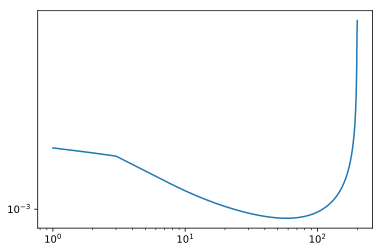

In [205]:
plt.loglog(1./altau)